# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

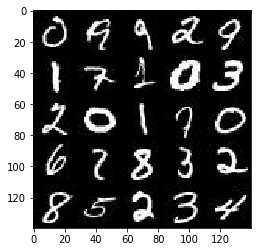

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

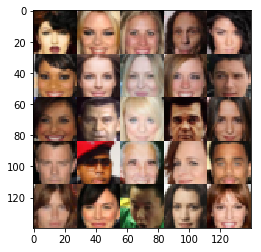

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [49]:
import numpy as np
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    #leaky relu hyperparameter
    alpha = 0.2
    #droupout hyperparameter
    drop_rate = 0.5
    
    with tf.variable_scope('discriminator', reuse=reuse):
        #28x28
        conv = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        conv = tf.maximum(alpha * conv, conv) #leaky relu allows gradient to flow
        conv = tf.layers.dropout(conv, drop_rate, training=True) #improves generalization and gets generator a chance to learn
        #print(conv.get_shape().as_list())
        
        #28x28x128
        conv = tf.layers.conv2d(conv, 256, 5, strides=2, padding='same')
        conv = tf.layers.batch_normalization(conv, training=True)
        conv = tf.maximum(alpha * conv, conv)
        conv = tf.layers.dropout(conv, drop_rate, training=True) #improves generalization and gets generator a chance to learn
        #print(conv.get_shape().as_list())
        
        #14x14x256
        conv = tf.layers.conv2d(conv, 512, 4, strides=2, padding='same')
        conv = tf.layers.batch_normalization(conv, training=True)
        conv = tf.maximum(alpha * conv, conv)
        conv = tf.layers.dropout(conv, drop_rate, training=True) #improves generalization and gets generator a chance to learn
        #print(conv.get_shape().as_list())
     
        #7x7x512
        flatten_shape = np.prod(conv.get_shape().as_list()[1:])
        flatten = tf.reshape(conv, [-1, flatten_shape])
        #print("Flatten shape: {}".format(flatten_shape))
    
        #classifier
        logits = tf.layers.dense(flatten, 1)
        output = tf.sigmoid(logits)
    
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [50]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    #leaky relu hyperparameter
    alpha = 0.2
    drop_rate = 0.1
    
    with tf.variable_scope('generator', reuse=not is_train):
        z = tf.layers.dense(z, 4*4*512, 
                            use_bias=False,
                            activation=None)
        z = tf.reshape(z, [-1, 4, 4, 512])
        z = tf.layers.batch_normalization(z, training=is_train)
        z = tf.maximum(alpha * z, z)
        #z = tf.layers.dropout(z, drop_rate, training=is_train)
        
        #print(z.get_shape().as_list())
        
        #4x4x512
        conv = tf.layers.conv2d_transpose(z, 256, 4, strides=1, padding='valid',
                                          use_bias=False,
                                          activation=None)
        conv = tf.layers.batch_normalization(conv, training=is_train)
        conv = tf.maximum(alpha * conv, conv)
        #conv = tf.layers.dropout(conv, drop_rate, training=is_train)
        #print(conv.get_shape().as_list())

        
        #7x7x256
        conv = tf.layers.conv2d_transpose(conv, 128, 5, strides=2, padding='same',
                                          use_bias=False,
                                          activation=None)
        conv = tf.layers.batch_normalization(conv, training=is_train)
        conv = tf.maximum(alpha * conv, conv)
        #conv = tf.layers.dropout(conv, drop_rate, training=is_train)
        #print(conv.get_shape().as_list())
        
        #14x14x128
        conv = tf.layers.conv2d_transpose(conv, out_channel_dim, 5, strides=2, padding='same',
                                          use_bias=False,
                                          activation=None)
        #print(conv.get_shape().as_list())
           
    return tf.nn.tanh(conv)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [51]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake))
                           )
    #avoiding always have 1's for real logits, we have to reduce these to allow generator to improve
    label_smoothing = 0.9
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * label_smoothing)
                           )
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake))
                           )
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [52]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    #retrieving trainable vars
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    #getting update ops for each one
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_update_ops = [op for op in update_ops if op.name.startswith('discriminator')]
    g_update_ops = [op for op in update_ops if op.name.startswith('generator')]
    
    #
    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [53]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [54]:
import numpy as np
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    #image mode
    out_channel_dim = 3 if data_image_mode == 'RGB' else 1

    #inputs, loss models and optmizers
    input_real, input_z, lr = model_inputs(*(data_shape[1:]), z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    ##
    step = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                step += 1
                
                #generate random sample
                z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                #images are in range [-0.5, 0.5], changing to [-1, 1]
                batch_images = batch_images * 2.0
                
                #compute loss
                _ = sess.run(d_train_opt, feed_dict={input_z: z, 
                                                     input_real: batch_images, 
                                                     lr: learning_rate})
                
                _ = sess.run(g_train_opt, feed_dict={input_z: z,
                                                     lr: learning_rate})
                
                #print outs
                if step % 25 == 0:
                    train_loss_d = d_loss.eval({input_z: z,
                                                input_real: batch_images,
                                                lr: learning_rate})
                    
                    train_loss_g = g_loss.eval({input_z: z,
                                                lr: learning_rate})

                    #print losses
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if step % 500 == 0:
                    #print images
                    show_generator_output(sess, 9, input_z, out_channel_dim, data_image_mode)
                
                
            print("End batch")
        print("End epoch")
    print("End")
    
    print("Final images:")
    show_generator_output(sess, 9, input_z, out_channel_dim, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6364... Generator Loss: 3.1828
Epoch 1/2... Discriminator Loss: 1.8606... Generator Loss: 1.0924
Epoch 1/2... Discriminator Loss: 1.1659... Generator Loss: 1.2968
Epoch 1/2... Discriminator Loss: 1.1871... Generator Loss: 1.9097
Epoch 1/2... Discriminator Loss: 1.6072... Generator Loss: 1.0037
Epoch 1/2... Discriminator Loss: 0.5689... Generator Loss: 2.6290
Epoch 1/2... Discriminator Loss: 0.6670... Generator Loss: 3.4137
Epoch 1/2... Discriminator Loss: 0.6897... Generator Loss: 3.3459
Epoch 1/2... Discriminator Loss: 0.4769... Generator Loss: 4.6549
Epoch 1/2... Discriminator Loss: 0.7277... Generator Loss: 3.7043
Epoch 1/2... Discriminator Loss: 0.5343... Generator Loss: 3.0887
Epoch 1/2... Discriminator Loss: 0.9391... Generator Loss: 1.8059
Epoch 1/2... Discriminator Loss: 1.6098... Generator Loss: 2.2790
Epoch 1/2... Discriminator Loss: 0.9064... Generator Loss: 1.5356
Epoch 1/2... Discriminator Loss: 0.8895... Generator Loss: 1.8112
Epoch 1/2.

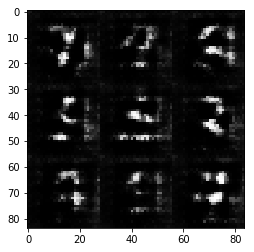

Epoch 1/2... Discriminator Loss: 1.4316... Generator Loss: 1.2666
Epoch 1/2... Discriminator Loss: 1.1418... Generator Loss: 1.9734
Epoch 1/2... Discriminator Loss: 1.0581... Generator Loss: 2.6375
Epoch 1/2... Discriminator Loss: 1.1115... Generator Loss: 1.2928
Epoch 1/2... Discriminator Loss: 1.1873... Generator Loss: 1.5076
Epoch 1/2... Discriminator Loss: 1.6344... Generator Loss: 1.3703
Epoch 1/2... Discriminator Loss: 1.4720... Generator Loss: 1.1966
Epoch 1/2... Discriminator Loss: 1.2627... Generator Loss: 1.3663
Epoch 1/2... Discriminator Loss: 1.4815... Generator Loss: 1.3035
Epoch 1/2... Discriminator Loss: 1.1797... Generator Loss: 1.5410
Epoch 1/2... Discriminator Loss: 1.2696... Generator Loss: 1.6535
Epoch 1/2... Discriminator Loss: 1.1410... Generator Loss: 1.6045
Epoch 1/2... Discriminator Loss: 1.2536... Generator Loss: 1.1654
Epoch 1/2... Discriminator Loss: 1.2685... Generator Loss: 1.3671
Epoch 1/2... Discriminator Loss: 1.0916... Generator Loss: 1.5227
Epoch 1/2.

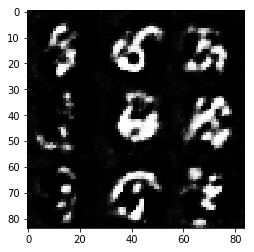

Epoch 1/2... Discriminator Loss: 1.0575... Generator Loss: 1.5189
Epoch 1/2... Discriminator Loss: 0.9062... Generator Loss: 1.4217
Epoch 1/2... Discriminator Loss: 1.0104... Generator Loss: 1.6030
Epoch 1/2... Discriminator Loss: 1.3226... Generator Loss: 1.2285
Epoch 1/2... Discriminator Loss: 1.2720... Generator Loss: 1.2489
Epoch 1/2... Discriminator Loss: 0.8812... Generator Loss: 1.3889
Epoch 1/2... Discriminator Loss: 1.1144... Generator Loss: 2.0976
Epoch 1/2... Discriminator Loss: 1.0640... Generator Loss: 1.9215
Epoch 1/2... Discriminator Loss: 1.2878... Generator Loss: 1.0597
Epoch 1/2... Discriminator Loss: 1.1234... Generator Loss: 1.3235
Epoch 1/2... Discriminator Loss: 1.5330... Generator Loss: 0.8655
Epoch 1/2... Discriminator Loss: 1.0576... Generator Loss: 1.5070
Epoch 1/2... Discriminator Loss: 0.9747... Generator Loss: 1.5728
Epoch 1/2... Discriminator Loss: 0.9685... Generator Loss: 1.3324
Epoch 1/2... Discriminator Loss: 1.2148... Generator Loss: 2.0987
Epoch 1/2.

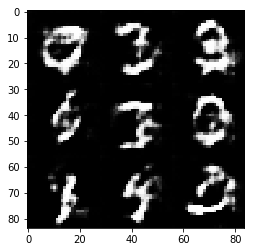

Epoch 1/2... Discriminator Loss: 1.3319... Generator Loss: 1.4040
Epoch 1/2... Discriminator Loss: 1.1021... Generator Loss: 1.1498
Epoch 1/2... Discriminator Loss: 1.2667... Generator Loss: 1.5238
Epoch 1/2... Discriminator Loss: 1.2046... Generator Loss: 1.0472
Epoch 1/2... Discriminator Loss: 1.1799... Generator Loss: 1.5472
Epoch 1/2... Discriminator Loss: 1.1826... Generator Loss: 1.7005
Epoch 1/2... Discriminator Loss: 1.4263... Generator Loss: 1.3522
Epoch 1/2... Discriminator Loss: 1.1459... Generator Loss: 1.3625
Epoch 1/2... Discriminator Loss: 1.1695... Generator Loss: 1.9249
Epoch 1/2... Discriminator Loss: 1.0390... Generator Loss: 1.3812
Epoch 1/2... Discriminator Loss: 0.9794... Generator Loss: 1.5603
Epoch 1/2... Discriminator Loss: 1.5118... Generator Loss: 0.6952
Epoch 1/2... Discriminator Loss: 1.0514... Generator Loss: 1.2560
Epoch 1/2... Discriminator Loss: 0.8018... Generator Loss: 1.5102
Epoch 1/2... Discriminator Loss: 1.0670... Generator Loss: 1.1800
End batch


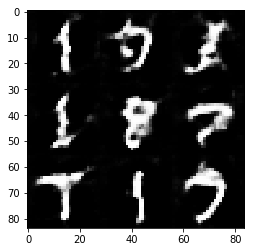

Epoch 2/2... Discriminator Loss: 1.3451... Generator Loss: 1.2278
Epoch 2/2... Discriminator Loss: 1.2316... Generator Loss: 1.2901
Epoch 2/2... Discriminator Loss: 1.1287... Generator Loss: 1.5057
Epoch 2/2... Discriminator Loss: 1.2541... Generator Loss: 1.8907
Epoch 2/2... Discriminator Loss: 1.2211... Generator Loss: 1.1837
Epoch 2/2... Discriminator Loss: 1.1514... Generator Loss: 0.9302
Epoch 2/2... Discriminator Loss: 1.2845... Generator Loss: 1.0153
Epoch 2/2... Discriminator Loss: 1.3461... Generator Loss: 0.7263
Epoch 2/2... Discriminator Loss: 1.2337... Generator Loss: 0.9408
Epoch 2/2... Discriminator Loss: 1.0646... Generator Loss: 1.6584
Epoch 2/2... Discriminator Loss: 1.2623... Generator Loss: 1.1180
Epoch 2/2... Discriminator Loss: 1.5141... Generator Loss: 0.9082
Epoch 2/2... Discriminator Loss: 1.1920... Generator Loss: 1.3541
Epoch 2/2... Discriminator Loss: 1.2574... Generator Loss: 1.4579
Epoch 2/2... Discriminator Loss: 1.3025... Generator Loss: 1.4153
Epoch 2/2.

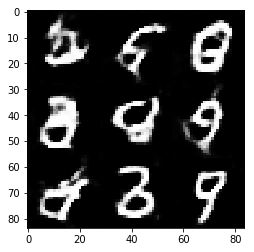

Epoch 2/2... Discriminator Loss: 1.5183... Generator Loss: 1.1797
Epoch 2/2... Discriminator Loss: 1.3688... Generator Loss: 0.7837
Epoch 2/2... Discriminator Loss: 1.1176... Generator Loss: 0.9167
Epoch 2/2... Discriminator Loss: 1.2421... Generator Loss: 1.0438
Epoch 2/2... Discriminator Loss: 1.2301... Generator Loss: 0.8148
Epoch 2/2... Discriminator Loss: 1.1408... Generator Loss: 1.3538
Epoch 2/2... Discriminator Loss: 1.4300... Generator Loss: 1.0409
Epoch 2/2... Discriminator Loss: 0.9905... Generator Loss: 0.9912
Epoch 2/2... Discriminator Loss: 1.2720... Generator Loss: 1.4143
Epoch 2/2... Discriminator Loss: 1.2196... Generator Loss: 1.0483
Epoch 2/2... Discriminator Loss: 1.0949... Generator Loss: 1.0656
Epoch 2/2... Discriminator Loss: 1.0823... Generator Loss: 1.3339
Epoch 2/2... Discriminator Loss: 1.3146... Generator Loss: 1.1307
Epoch 2/2... Discriminator Loss: 1.2793... Generator Loss: 1.0724
Epoch 2/2... Discriminator Loss: 1.2409... Generator Loss: 1.3522
Epoch 2/2.

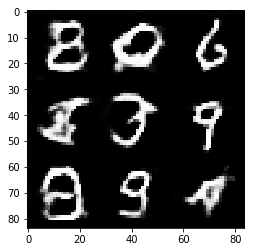

Epoch 2/2... Discriminator Loss: 1.3493... Generator Loss: 1.3436
Epoch 2/2... Discriminator Loss: 1.1843... Generator Loss: 1.1205
Epoch 2/2... Discriminator Loss: 1.2768... Generator Loss: 1.1176
Epoch 2/2... Discriminator Loss: 1.1105... Generator Loss: 0.7321
Epoch 2/2... Discriminator Loss: 1.1870... Generator Loss: 1.4424
Epoch 2/2... Discriminator Loss: 1.3441... Generator Loss: 1.5208
Epoch 2/2... Discriminator Loss: 1.3240... Generator Loss: 0.8192
Epoch 2/2... Discriminator Loss: 1.4293... Generator Loss: 1.2338
Epoch 2/2... Discriminator Loss: 1.1031... Generator Loss: 0.9847
Epoch 2/2... Discriminator Loss: 1.2698... Generator Loss: 0.9809
Epoch 2/2... Discriminator Loss: 1.1933... Generator Loss: 0.9740
Epoch 2/2... Discriminator Loss: 1.1911... Generator Loss: 1.0710
Epoch 2/2... Discriminator Loss: 1.1180... Generator Loss: 1.0483
Epoch 2/2... Discriminator Loss: 1.1668... Generator Loss: 1.1408
Epoch 2/2... Discriminator Loss: 1.0112... Generator Loss: 0.9572
Epoch 2/2.

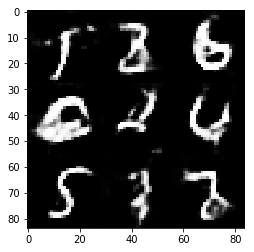

Epoch 2/2... Discriminator Loss: 1.1912... Generator Loss: 0.9846
Epoch 2/2... Discriminator Loss: 1.1819... Generator Loss: 1.2114
Epoch 2/2... Discriminator Loss: 1.2993... Generator Loss: 0.9864
Epoch 2/2... Discriminator Loss: 1.0894... Generator Loss: 1.4080
Epoch 2/2... Discriminator Loss: 1.4136... Generator Loss: 1.1675
Epoch 2/2... Discriminator Loss: 1.2377... Generator Loss: 0.8867
Epoch 2/2... Discriminator Loss: 1.3437... Generator Loss: 1.0034
Epoch 2/2... Discriminator Loss: 1.3449... Generator Loss: 1.1668
Epoch 2/2... Discriminator Loss: 1.2926... Generator Loss: 1.1383
Epoch 2/2... Discriminator Loss: 1.0279... Generator Loss: 0.6899
End batch
End epoch
End


In [55]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4081... Generator Loss: 4.8213
Epoch 1/1... Discriminator Loss: 0.3786... Generator Loss: 4.8308
Epoch 1/1... Discriminator Loss: 0.5728... Generator Loss: 6.1573
Epoch 1/1... Discriminator Loss: 1.1731... Generator Loss: 8.8444
Epoch 1/1... Discriminator Loss: 0.4739... Generator Loss: 3.0566
Epoch 1/1... Discriminator Loss: 0.7431... Generator Loss: 3.7924
Epoch 1/1... Discriminator Loss: 0.3881... Generator Loss: 4.4067
Epoch 1/1... Discriminator Loss: 0.4743... Generator Loss: 5.0385
Epoch 1/1... Discriminator Loss: 0.5595... Generator Loss: 2.2359
Epoch 1/1... Discriminator Loss: 2.1444... Generator Loss: 7.4743
Epoch 1/1... Discriminator Loss: 0.5990... Generator Loss: 4.8513
Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 5.4381
Epoch 1/1... Discriminator Loss: 1.0204... Generator Loss: 0.8339
Epoch 1/1... Discriminator Loss: 0.9176... Generator Loss: 2.8008
Epoch 1/1... Discriminator Loss: 1.7408... Generator Loss: 4.2553
Epoch 1/1.

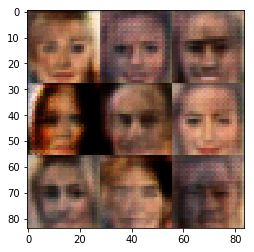

Epoch 1/1... Discriminator Loss: 0.8288... Generator Loss: 1.4282
Epoch 1/1... Discriminator Loss: 0.5387... Generator Loss: 2.5972
Epoch 1/1... Discriminator Loss: 0.7639... Generator Loss: 1.3709
Epoch 1/1... Discriminator Loss: 1.0361... Generator Loss: 5.7651
Epoch 1/1... Discriminator Loss: 0.6650... Generator Loss: 1.6970
Epoch 1/1... Discriminator Loss: 0.6978... Generator Loss: 1.5977
Epoch 1/1... Discriminator Loss: 0.5986... Generator Loss: 1.9721
Epoch 1/1... Discriminator Loss: 0.4715... Generator Loss: 6.7819
Epoch 1/1... Discriminator Loss: 3.3247... Generator Loss: 6.8134
Epoch 1/1... Discriminator Loss: 0.7140... Generator Loss: 1.4194
Epoch 1/1... Discriminator Loss: 0.4318... Generator Loss: 3.0704
Epoch 1/1... Discriminator Loss: 0.3904... Generator Loss: 4.5271
Epoch 1/1... Discriminator Loss: 0.4161... Generator Loss: 5.8889
Epoch 1/1... Discriminator Loss: 0.5145... Generator Loss: 2.1872
Epoch 1/1... Discriminator Loss: 0.3809... Generator Loss: 5.1616
Epoch 1/1.

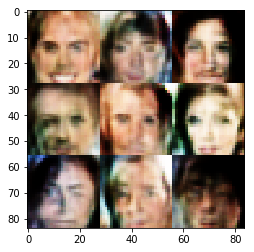

Epoch 1/1... Discriminator Loss: 0.4791... Generator Loss: 4.2151
Epoch 1/1... Discriminator Loss: 0.4403... Generator Loss: 3.3352


KeyboardInterrupt: 

In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.